# Multi-Layer Perceptron (MLP)

In [5]:
##all coding is runing on env theano_3
# set plots inline for ipython
# %matplotlib inline

# import system & ipython utils
import os
import subprocess
from IPython.display import Image
import time

# numpy and visualization libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import data preprocessing, cross validaiton

from sklearn.preprocessing import StandardScaler


from sklearn.tree import export_graphviz

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# performance measures
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, hamming_loss, mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

# # personal libs
# from mwutil.ml import run_training_range
# from mwutil.ml import compare_classifiers

# set random seed
rand_state = np.random.RandomState(32)
# set the scoring function
# set the scoring function
scoring_function_label = 'f1_weighted'
scoring_function = f1_score

# set number of folds for cross validation
n_folds = 3

# init an empty dict to hold all models for final analysis & comparison
classifiers = {}

# define the number of 'stages' aka bins to map the UPDRS scores
n_stages = 55

# set updrs metric (total or motor)
#updrs_measure = 'total_UPDRS'

# subsampling (-1 for no subsampling)
subsample_n = -1

In [6]:
import numpy as np
import pandas as pd
import warnings

## Plotting libraries
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Sklearn Libraries
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_predict
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve, roc_auc_score, precision_score, accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import get_scorer

## XGBoost Librarires
from xgboost import XGBClassifier

# pickle library
import pickle

## Scipy Libraries
from scipy.stats.mstats import winsorize
from scipy.stats import f
from scipy.stats import norm
from scipy.stats import chi2
from scipy.stats import ttest_ind
from scipy.stats import randint
from scipy.stats import yeojohnson

#statistics
from statistics import stdev 

#itertools
from itertools import combinations, permutations

#mlxtend
from mlxtend.evaluate import paired_ttest_5x2cv
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

#math
import math

# Define random state
random_state = 2020
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [7]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear = nn.Linear(3, 2)
        self.soft = nn.Softmax(dim=1)
    def forward(self, x):
        out = self.soft(self.linear(x))
        # out = self.linear(x)
        return out

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print(model)
'''
MLP(
  (linear): Linear(in_features=3, out_features=10, bias=True)
)
'''

MLP(
  (linear): Linear(in_features=3, out_features=2, bias=True)
  (soft): Softmax(dim=1)
)


'\nMLP(\n  (linear): Linear(in_features=3, out_features=10, bias=True)\n)\n'

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# set path to all_dataset
raw_data_path = './original_score_all.csv'
df = pd.read_csv(raw_data_path)

df.columns=['ID', 'score_max', 'score_mean', 'score_median', 'class']

# split X (features), y (PD stage label) from the dataframe
features = ['score_max', 'score_mean', 'score_median']
df_plot=['score_max', 'score_mean', 'score_median', 'class']
X = df[features]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rand_state)

# fit a standardScaler to normalize all input to zero mean and unit variance
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [11]:
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self, data,y):
        self.data = data
        self.y = y
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, ind):
        x = self.data[ind]
        y = self.y[ind]
        return x, y
class TestDataset(TrainDataset):
    def __getitem__(self, ind):
        x = self.data[ind]
        return x

train_set = TrainDataset(X_train.values, y_train.to_numpy())
test_set  = TestDataset(X_test.values, y_test.to_numpy())

batch_size = 64
train_loader = DataLoader(train_set,  shuffle=True, batch_size=batch_size)
test_loader  = DataLoader(test_set,  shuffle=False, batch_size=batch_size)

In [12]:
from sklearn import metrics

epochs = 100

model.train()
for epoch in range(epochs):
    losses = []
    for batch_num, input_data in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = input_data
        x = x.to(device).float()
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

        if batch_num % 40 == 0:
            print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
            y_pred = output.detach().cpu().argmax(dim=1).numpy()
            y_score = output.detach().cpu().max(dim=1).values
            print('\tEpoch %d | Batch %d | Acc %6.2f' % (epoch, batch_num, metrics.accuracy_score(y.detach().cpu().numpy(),y_pred)))
    print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))

	Epoch 0 | Batch 0 | Loss   0.89
	Epoch 0 | Batch 0 | Acc   0.20
Epoch 0 | Loss   0.92
	Epoch 1 | Batch 0 | Loss   0.93
	Epoch 1 | Batch 0 | Acc   0.06
Epoch 1 | Loss   0.90
	Epoch 2 | Batch 0 | Loss   0.92
	Epoch 2 | Batch 0 | Acc   0.08
Epoch 2 | Loss   0.89
	Epoch 3 | Batch 0 | Loss   0.88
	Epoch 3 | Batch 0 | Acc   0.11
Epoch 3 | Loss   0.90
	Epoch 4 | Batch 0 | Loss   0.93
	Epoch 4 | Batch 0 | Acc   0.03
Epoch 4 | Loss   0.89
	Epoch 5 | Batch 0 | Loss   0.88
	Epoch 5 | Batch 0 | Acc   0.11
Epoch 5 | Loss   0.88
	Epoch 6 | Batch 0 | Loss   0.90
	Epoch 6 | Batch 0 | Acc   0.11
Epoch 6 | Loss   0.87
	Epoch 7 | Batch 0 | Loss   0.88
	Epoch 7 | Batch 0 | Acc   0.09
Epoch 7 | Loss   0.86
	Epoch 8 | Batch 0 | Loss   0.87
	Epoch 8 | Batch 0 | Acc   0.09
Epoch 8 | Loss   0.87
	Epoch 9 | Batch 0 | Loss   0.87
	Epoch 9 | Batch 0 | Acc   0.08
Epoch 9 | Loss   0.85
	Epoch 10 | Batch 0 | Loss   0.83
	Epoch 10 | Batch 0 | Acc   0.12
Epoch 10 | Loss   0.85
	Epoch 11 | Batch 0 | Loss   0.84
	Epoch

Epoch 99 | Loss   0.49


In [8]:
from sklearn.neural_network import MLPClassifier

In [215]:
# for simplicity I choose 3 layers with the same number of neurons as there are features in my data set
mlp_hidden_layer_sizes = [(3,3)]
mlp_activation = ['tanh', 'relu', 'logistic']
mlp_solver = ['lbfgs', 'sgd', 'adam']
mlp_alpha = np.linspace(0.0001,0.1,10)
mlp_eta = ['constant','invscaling','adaptive']
mlp_grid = {'mlpclassifier__hidden_layer_sizes': mlp_hidden_layer_sizes,
            'mlpclassifier__activation': mlp_activation,
            'mlpclassifier__solver': mlp_solver,
            'mlpclassifier__alpha': mlp_alpha,
            'mlpclassifier__learning_rate': mlp_eta
}

mlp = MLPClassifier(random_state = 32)

In [216]:
pipe_lr = make_pipeline(PowerTransformer(method='yeo-johnson',standardize = True),
                                    PCA(n_components = 0.99),
                                    mlp)
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state = random_state)

In [217]:
search_mlp = RandomizedSearchCV(estimator=pipe_lr, param_distributions = mlp_grid, cv = cv, n_jobs=-1, verbose=True, scoring = 'roc_auc', refit = True, n_iter = 50)


In [218]:
search_mlp.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=32, shuffle=True),
                   estimator=Pipeline(steps=[('powertransformer',
                                              PowerTransformer()),
                                             ('pca', PCA(n_components=0.99)),
                                             ('mlpclassifier',
                                              MLPClassifier(random_state=32))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'mlpclassifier__activation': ['tanh',
                                                                      'relu',
                                                                      'logistic'],
                                        'mlpclassifier__alpha': array([0.0001, 0.0112, 0.0223, 0.0334, 0.0445, 0.0556, 0.0667, 0.0778,
       0.0889, 0.1   ]),
                                        'mlpclassifier__hidden_layer_sizes': [(3,
                                         

In [16]:
# set path to dataset

raw_data_path = './original_score_all.csv'

df = pd.read_csv(raw_data_path)

df.columns=['ID', 'score_max', 'score_mean', 'score_median', 'class']

# split X (features), y (PD stage label) from the dataframe
features = ['score_max', 'score_mean', 'score_median']

X = df[features]
y = df['class']

In [17]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rand_state)

# fit a standardScaler to normalize all input to zero mean and unit variance
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [41]:
y_pred = model(torch.from_numpy(X_test.values).to(device).float()).detach().cpu().argmax(dim=1).numpy()

## calculate the evaluation result of MLP

In [237]:

from sklearn import metrics

def evaluate_clustering(lst_true_label, lst_pred_label, encoding=None, affinity=None, eval_method=range(1,10),**kwargs):
    '''
    Output: a dict with 'method_name'-'score' as key-value pairs.

    - `eval_method` (list) indicates which method to use.
        Nine types of evaluation methods available :
            0. Accuracy, Precision, Recall, F1-Score
            1. Rand Score (Index) and Adjusted Rand Score (Index)
            2. Mutual Information based scores (NMI score and AMI score)
            3. Homogeneity, completeness and V-measure
            4. Fowlkes-Mallows scores
            5. Silhouette Coefficient
            6. Calinski-Harabasz Index
            7. Davies-Bouldin Index
            8. Contingency Matrix
            9. Pair Confusion Matrix

    - The input `encoding` is a must-have input only for 
        `5. Silhouette Coefficient`, 
        `6. Calinski-Harabasz Index`, 
        `7. Davies-Bouldin Index`. 

    - The input `affinity` is an optional input only for `5. Silhouette Coefficient` method   
    
    Note that :
    1/ the following clustering evaluation methods are symmetric: swapping the argument does not change the scores.
        1. Rand Index (RI), Adjusted Rand Index (ARI)
        2. Mutual Information (MI), Adjusted Mutual Information (AMI), Normalised Mutual Information (NMI)
        3. V-measure Score

    2/ For Precision, Recall, F1-Score, Fbeta in method 0, by default the `1`s in the true/pred label are regraded as `Positive Examlpe`, but a `pos_label` parameter can be fed to them to indicate the positive labels.

    More details at: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
    '''
    res = {}
    # 0. Accuracy, Precision, Recall, F1-Score, Fbeta
    if 0 in eval_method:
        res["0_accuracy"] = metrics.accuracy_score(lst_true_label, lst_pred_label)
        pos_label = kwargs["pos_label"] if "pos_label" in kwargs.keys() else 1
        res["0_precision"],res["0_sensitivity"],res["0_f1_score"] = \
            metrics.precision_score(lst_true_label, lst_pred_label,pos_label=pos_label), metrics.recall_score(lst_true_label, lst_pred_label,pos_label=pos_label), metrics.f1_score(lst_true_label, lst_pred_label,pos_label=pos_label)
        cm = metrics.confusion_matrix(lst_true_label, lst_pred_label)
        tn, fp, fn, tp = cm.ravel()
        res["0_specificity"] = tn/(tn+fp) if tn+fp!=0 else tn        
        
        if "fbeta":
            if "beta_fbeta" in kwargs.keys():
                beta_fbeta = kwargs["beta_fbeta"]
            else:
                beta_fbeta = 2
            res[f"0_f{beta_fbeta}_score"] = metrics.fbeta_score(lst_true_label, lst_pred_label,pos_label=pos_label, beta=beta_fbeta)
    # 1. Rand Score
    if 1 in eval_method:
        res["1_rand score"] = metrics.rand_score(lst_true_label, lst_pred_label)
        res["1_adjusted_rand_score"] = metrics.adjusted_rand_score(lst_true_label, lst_pred_label)
    # 2. Mutual Information based scores
    if 2 in eval_method:
        res["2_NMI score"] = metrics.normalized_mutual_info_score(lst_true_label, lst_pred_label)
        res["2_AMI score"] = metrics.adjusted_mutual_info_score(lst_true_label, lst_pred_label)
    # 3. Homogeneity, completeness and V-measure
    if 3 in eval_method:
        res["3_homogeneity_score"] = metrics.homogeneity_score(lst_true_label, lst_pred_label)
        res["3_completeness_score"] = metrics.completeness_score(lst_true_label, lst_pred_label)
        res["3_v_measure_score"] = metrics.v_measure_score(lst_true_label, lst_pred_label, beta=1.0)
    # 4. Fowlkes-Mallows scores
    if 4 in eval_method:
        res["4_fowlkes_mallows_score"] = metrics.fowlkes_mallows_score(lst_true_label, lst_pred_label)
    # 5. Silhouette Coefficient
    if 5 in eval_method and encoding is not None :
        try:
            if affinity is not None:
                res["5_silhouette_score"] = metrics.silhouette_score(encoding, lst_pred_label, metric=affinity)
            else:
                res["5_silhouette_score"] = metrics.silhouette_score(encoding, lst_pred_label)
        except:
            res["5_silhouette_score"] = None
    # 6. Calinski-Harabasz Index
    if 6 in eval_method and encoding is not None:
        try:
            res["6_calinski_harabasz_score"] = metrics.calinski_harabasz_score(encoding, lst_pred_label)
        except:
            res["6_calinski_harabasz_score"] = None
    # 7. Davies-Bouldin Index
    if 7 in eval_method and encoding is not None:
        try:
            res["7_davies_bouldin_score"] = metrics.davies_bouldin_score(encoding, lst_pred_label)
        except:
            res["7_davies_bouldin_score"] = None
    # 8. Contingency Matrix
    if 8 in eval_method:
        res["8_Contingency Matrix"] = metrics.cluster.contingency_matrix(lst_true_label, lst_pred_label)
    # 9. Pair Confusion Matrix
    if 9 in eval_method:
        res["9_pair_confusion_matrix"] = metrics.cluster.pair_confusion_matrix(lst_true_label, lst_pred_label)
    return res



In [257]:
search_mlp.fit(X_train, y_train)
evaluate_clustering(y_test, search_mlp.predict(X_test), eval_method=[0])

Fitting 4 folds for each of 50 candidates, totalling 200 fits


{'0_accuracy': 0.9377431906614786,
 '0_precision': 0.7692307692307693,
 '0_sensitivity': 0.43478260869565216,
 '0_f1_score': 0.5555555555555555,
 '0_specificity': 0.9871794871794872,
 '0_f2_score': 0.47619047619047616}

# Compared 3 kind of classifiers

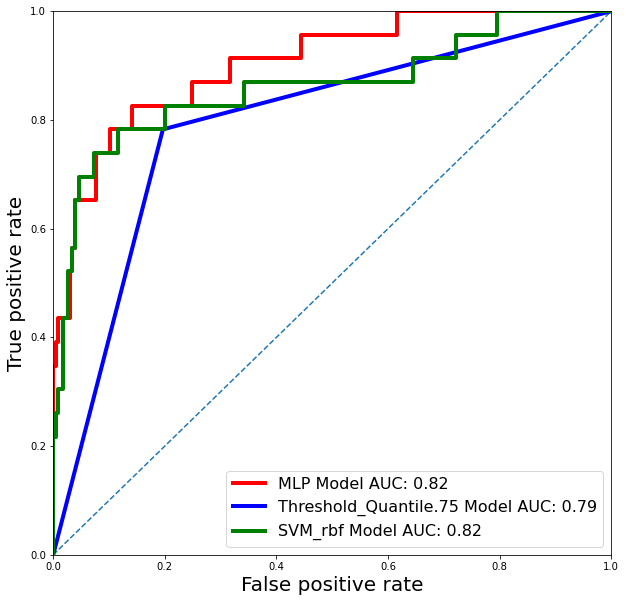

In [195]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#total = len(y_test)
#class_1_count = np.sum(y_test)
#class_0_count = total - class_1_count
plt.figure(figsize = (10, 10))

fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, predict_rdf)
modelauc_mlp = roc_auc_score(y_test, y_pred)
# mlp Model
    
plt.plot([0, 1], [0, 1], linestyle='--')
# Perfect Model
plt.plot(fpr_mlp, tpr_mlp, 
         c = 'r', 
         linewidth = 4, 
         label = 'MLP Model AUC:' + ' {0:.2f}'.format(modelauc_mlp))

#th 75   
modelauc_th75 = roc_auc_score(y_test, y_pred_quantile75)
fpr_th75, tpr_th75, thresholds_th75 = roc_curve(y_test, y_pred_quantile75)    

plt.plot(fpr_th75, tpr_th75, 
         c = 'b', 
         label = 'Threshold_Quantile.75 Model AUC:' + ' {0:.2f}'.format(modelauc_th75), 
         linewidth = 4)
# ml Model
svm_rbf.fit(X_train,y_train)
y_pred_ml = svm_rbf.predict(X_test)
probs = svm_rbf.predict_proba(X_test)
probs = probs[:, 1]
fpr_0, tpr_0, thresholds_0 = roc_curve(y_test, probs)
modelauc_ml = roc_auc_score(y_test, y_pred_ml)
plt.plot(fpr_0, tpr_0, 
         c = 'g', 
         label = 'SVM_rbf Model AUC:' + ' {0:.2f}'.format(modelauc_ml), 
         linewidth = 4)          
# Plot information
plt.xlabel('False positive rate', fontsize = 20)
plt.ylabel('True positive rate', fontsize = 20)
plt.xlim(left=0,right=1)
plt.ylim(bottom=0,top=1)
#plt.title('Cumulative Accuracy Profile', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

# Use DeLong to do the significant test between AUC of 3 classifiers

In [188]:
import numpy as np
import scipy.stats


# AUC comparison adapted from
# https://github.com/Netflix/vmaf/

# AUC comparison adapted from https://github.com/yandexdataschool/roc_comparison
def compute_midrank(x):
    """Computes midranks.
    Parameters:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Parameters:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Parameters:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    p_val = np.log10(2) + norm.logsf(z, loc=0, scale=1) / np.log(10)
    
    p_val = math.exp(p_val)
    
    return p_val


def compute_ground_truth_statistics(ground_truth, sample_weight=None):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Parameters:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    sample_weight = None
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Parameters:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    sample_weight = None
    order, label_1_count, a = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

def calc_auc_ci(y_true, y_pred, alpha=0.95):
    auc, auc_cov = delong_roc_variance(y_true,y_pred)
    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    ci = norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1
    return ci



In [100]:
import ipynb.fs.full.DeLong_Test as delong
import ipynb.fs.full.Bootstrap_Test as bootstrap
import numpy as np
class Scoring(object):
    def __init__(self, base_models):
        self.base_models = base_models

    def delong_test(self, predict_df_all, labels):
        
        """
        Computes p-value of DeLong Test with hypothesis that ROC AUCs of two classifiers are different
        Parameters:
            predict_df_all: dataframe with predictions of the classifiers for all three sets of predictors ('ALL', 'PDE', 'PD')
            labels: test set; dataframe with dependent variable as column

            return: 
                Test_df_sets: dataframe with results of paired test comparing ROC AUCs of different sets ('ALL' vs 'PDE' and 'ALL' vs 'PD') for all classifiers
                Test_df_all: dataframe with results of paired test comparing ROC AUCs for all classifiers built based on set of all variables ('ALL')
        """

        Test_df_sets = pd.DataFrame(np.zeros((2, len(self.base_models))), index=['ALL/PDE','ALL/PD'], columns=[str(i).split('(')[0].lower() for i in self.base_models])
        Test_df_sets.columns = pd.MultiIndex.from_product([['DeLong Test'], Test_df_sets.columns])
        
        Test_df_all = pd.DataFrame(list(combinations(Test_df_sets['DeLong Test'].columns,2)),columns = ['1st Algorithm', '2nd Algorithm'])
        Test_df_all['score'] = 0
        Test_df_all.columns = pd.MultiIndex.from_product([['DeLong Test'], Test_df_all.columns])    
            
        for i, clf in enumerate(self.base_models):
        
            Test_df_sets['DeLong Test'].loc['ALL/PDE',str(clf).split('(')[0].lower()] = delong.delong_roc_test(labels.values.ravel(), predict_df_all['ALL'][str(clf).split('(')[0].lower()], predict_df_all['PDE'][str(clf).split('(')[0].lower()])
            Test_df_sets['DeLong Test'].loc['ALL/PD',str(clf).split('(')[0].lower()] = delong.delong_roc_test(labels.values.ravel(), predict_df_all['ALL'][str(clf).split('(')[0].lower()], predict_df_all['PD'][str(clf).split('(')[0].lower()])
        
        for j in range(Test_df_all.shape[0]):
            Test_df_all.loc[j, ('DeLong Test', 'score')]  = delong.delong_roc_test(labels.values.ravel(), predict_df_all['ALL'][Test_df_all.loc[j, ('DeLong Test', '1st Algorithm')]], predict_df_all['ALL'][Test_df_all.loc[j, ('DeLong Test', '2nd Algorithm')]])
       
        return Test_df_sets, Test_df_all
    
    def bootstrap_test(self, predict_df_all, labels):
        
        """
        Computes p-value of Bootstrap Test with hypothesis that ROC AUCs of two classifiers are different
        Parameters:
            predict_df_all: dataframe with predictions of the classifiers for all three sets of predictors ('ALL', 'PDE', 'PD')
            labels: test set; dataframe with dependent variable as column

            return: 
                Test_df_sets: dataframe with results of paired test comparing ROC AUCs of different sets ('ALL' vs 'PDE' and 'ALL' vs 'PD') for all classifiers
                Test_df_all: dataframe with results of paired test comparing ROC AUCs for all classifiers built based on set of all variables ('ALL')
        """
        
        Test_df_sets = pd.DataFrame(np.zeros((2, len(self.base_models))), index=['ALL/PDE','ALL/PD'], columns=[str(i).split('(')[0].lower() for i in self.base_models])
        Test_df_sets.columns = pd.MultiIndex.from_product([['Bootstrap Test'], Test_df_sets.columns])
        
        Test_df_all = pd.DataFrame(list(combinations(Test_df_sets['Bootstrap Test'].columns,2)),columns = ['1st Algorithm', '2nd Algorithm'])
        Test_df_all['score'] = 0
        Test_df_all.columns = pd.MultiIndex.from_product([['Bootstrap Test'], Test_df_all.columns])
            
        for i, clf in enumerate(self.base_models):
        
            Test_df_sets['Bootstrap Test'].loc['ALL/PDE',str(clf).split('(')[0].lower()] = bootstrap.pvalue(labels.values.ravel(), predict_df_all['ALL'][str(clf).split('(')[0].lower()], predict_df_all['PDE'][str(clf).split('(')[0].lower()], score_fun=roc_auc_score)
            Test_df_sets['Bootstrap Test'].loc['ALL/PD',str(clf).split('(')[0].lower()] = bootstrap.pvalue(labels.values.ravel(), predict_df_all['ALL'][str(clf).split('(')[0].lower()], predict_df_all['PD'][str(clf).split('(')[0].lower()], score_fun=roc_auc_score)
            
        for j in range(Test_df_all.shape[0]):
            Test_df_all.loc[j, ('Bootstrap Test', 'score')]  = bootstrap.pvalue(labels.values.ravel(), predict_df_all['ALL'][Test_df_all.loc[j, ('Bootstrap Test', '1st Algorithm')]], predict_df_all['ALL'][Test_df_all.loc[j, ('Bootstrap Test', '2nd Algorithm')]],score_fun=roc_auc_score)
       
        return Test_df_sets, Test_df_all
    
    def likelihood_RT(self, predict_df_all, estimators, x_train, y_test):
        
        """
        Computes p-value of Likelihood Ratio Test with hypothesis that ROC AUCs of Logistic Regression models built on different sets of variables are different
        Parameters:
            predict_df_all: dataframe with predictions of the classifiers for all three sets of predictors ('ALL', 'PDE', 'PD')
            classifiers: list of best classifiers' instances fitted to the model
            x_train: training set; dataframe with predictors as columns
            labels: test set; dataframe with dependent variable as column

            return: 
                Test_df_sets: dataframe with results of paired test comparing ROC AUCs of different sets ('ALL' vs 'PDE' and 'ALL' vs 'PD') for all classifiers
        """
        
        Test_df_sets = pd.DataFrame((np.zeros((2, 1))), index=['ALL/PDE','ALL/PD'], columns=[str(classifiers[2])])
        Test_df_sets.columns = pd.MultiIndex.from_product([['LRT'], Test_df_sets.columns])

        alt_log_likelihood = -log_loss(y_test,
                                       predict_df_all['ALL'][str(classifiers[2])],
                                       normalize=False)
        null_log_likelihood = -log_loss(y_test,
                                        predict_df_all['PDE'][str(classifiers[2])],
                                        normalize=False)
        G = 2 * (alt_log_likelihood - null_log_likelihood)
        p_log_l = chi2.sf(G, x_train.shape[1])
        
        alt_log_likelihood = -log_loss(y_test,
                                       predict_df_all['ALL'][str(classifiers[2])],
                                       normalize=False)
        null_log_likelihood = -log_loss(y_test,
                                        predict_df_all['PD'][str(classifiers[2])],
                                        normalize=False)
        
        G = 2 * (alt_log_likelihood - null_log_likelihood)
        p_log_2 = chi2.sf(G, x_train.shape[1])
        
        Test_df_sets['LRT'].loc['ALL/PDE' ,str(classifiers[2])] = p_log_l
        Test_df_sets['LRT'].loc['ALL/PD', str(classifiers[2])] = p_log_2

        return Test_df_sets

    
def graph_ci_alternative(predict_df_all, y_test, base_models):

    """
    Confidence Intervals for given set of predictors
    Parameters:
        predict_df_all: dataframe with predictions of the classifiers for all sets of predictors ('ALL', 'PDE', 'PD')
        y_test: test set; dataframe with dependent variable as column
        base_models: List with set of classifiers

        return: Graph showing the Confidence Intervals of all classifiers for given set of predictors
    """
    predict_df = predict_df_all.copy(deep=False)

    result_table = pd.DataFrame(columns=['classifiers', 'delong','bootstrap'])
    for i, (j, clf) in enumerate(predict_df):
        yproba = predict_df[j][clf]

        delong = delong.calc_auc_ci(y_test.values.ravel(),  yproba, alpha=0.95) 
        bootstrap = bootstrap.score_stat_ci(y_test.values.ravel(), yproba,  roc_auc_score)

        result_table = result_table.append({'classifiers': [j,clf],
                                            'delong':delong, 
                                            'bootstrap':bootstrap}, ignore_index=True)

        result_table[['set', 'classifier']] = pd.DataFrame(result_table['classifiers'].tolist(), index=result_table.index)

    for k,m in enumerate(result_table.set.unique()):

        plt.figure(figsize=(8,6))

        SMALL_SIZE = 10
        MEDIUM_SIZE = 12
        BIGGER_SIZE = 14

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

        x_ticks = [str(i).split('(')[0].lower() for i in base_models]

        for n,l in enumerate(result_table.classifier.unique()):

            eb_1 = plt.errorbar(x=n+1, 
                             y=(result_table.loc[(result_table.classifier == str(l)) & (result_table.set == str(m))]['bootstrap'].values[0][1] + result_table.loc[(result_table.classifier == str(l)) & (result_table.set == str(m))]['bootstrap'].values[0][0])/2, 
                             yerr=[(result_table.loc[(result_table.classifier == str(l)) & (result_table.set == str(m))]['bootstrap'].values[0][1] - result_table.loc[(result_table.classifier == str(l)) & (result_table.set == str(m))]['bootstrap'].values[0][0])/2],
                             fmt='ok',
                             capsize = 10)

            eb_2 = plt.errorbar(x=n+1.1, 
                             y=(result_table.loc[(result_table.classifier == str(l)) & (result_table.set == str(m))]['delong'].values[0][1] + result_table.loc[(result_table.classifier == str(l)) & (result_table.set == str(m))]['delong'].values[0][0])/2, 
                             yerr=[(result_table.loc[(result_table.classifier == str(l)) & (result_table.set == str(m))]['delong'].values[0][1] - result_table.loc[(result_table.classifier == str(l)) & (result_table.set == str(m))]['delong'].values[0][0])/2],
                             fmt='ok',
                             capsize = 10)
            eb_2[-1][0].set_linestyle('--')

            # I need to manipulate 3rd parameter in arange, so the graph looks nice & I also need to do the same in errorbar(x)

            plt.xticks(np.arange(1.05,len(x_ticks)+0.5,1), x_ticks, rotation=90)
            plt.tight_layout()

            plt.ylabel("ROC AUC Przedział Ufności", fontsize=15)
            plt.tight_layout()

        plt.savefig('plot'+str(m)+'ci.png', dpi=1200)
        plt.show()
        plt.close()

In [170]:
SVM_prob = search.best_estimator_.predict_proba(X_test)[:,1].astype('float64')

In [196]:
delong_roc_test(np.array(y_test),y_pred_quantile5,y_pred_quantile75)

0.12003852956721218

In [186]:
delong_roc_test(np.array(y_test),SVM_probe,MLP_probs)

0.23773628662316804

In [197]:
delong_roc_test(np.array(y_test),MLP_probs,y_pred_quantile75)

0.006762222082778825

In [199]:
delong_roc_test(np.array(y_test),SVM_probe,y_pred_quantile75)

0.10981800355531782

# Screening for Potential Cancer

In [243]:
def get_bad_data(all_dataframe,clf):    
    res=[]
    M = np.empty(shape=[2, 2])
    X=all_dataframe[features]
    y=all_dataframe['class']

    clf.fit(X,y)
    y_pred=clf.predict(X)
    print(y_pred)
    index = np.arange(0,len(y))
    bad_index=index[y != y_pred]
    for i in bad_index:
            bad=str(all_dataframe["class"][i])+"_"+str(all_dataframe["ID"][i])
            res.append(bad)
    return res

In [233]:
svc_grid=SVC(C=451, cache_size=200, class_weight='balanced', coef0=0.0,
   decision_function_shape="ovo", degree=3, gamma=0.32222222222222224, kernel='rbf',
   max_iter=-1, probability=False,
   random_state=rand_state, shrinking=True,
   tol=0.001, verbose=False)

In [234]:
get_bad_data(df, svc_grid)

[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 

['1_2',
 '0_6',
 '0_30',
 '0_32',
 '0_34',
 '0_49',
 '0_62',
 '0_68',
 '1_75',
 '1_82',
 '0_85',
 '0_86',
 '0_126',
 '1_140',
 '1_151',
 '0_163',
 '0_235',
 '0_241',
 '0_274',
 '0_299',
 '0_314',
 '0_318',
 '0_329',
 '1_353',
 '0_356',
 '1_364',
 '1_374',
 '0_378',
 '0_382',
 '0_393',
 '0_417',
 '0_452',
 '0_458',
 '0_461',
 '0_463',
 '1_469',
 '0_493',
 '0_522',
 '0_561',
 '0_596',
 '1_608',
 '0_619',
 '1_634',
 '0_639',
 '0_641',
 '0_653',
 '0_681',
 '1_682',
 '0_683',
 '0_684',
 '0_688',
 '0_721',
 '0_726',
 '0_731',
 '0_738',
 '0_750',
 '0_762',
 '0_768',
 '0_776',
 '0_781',
 '0_812',
 '0_815',
 '0_846',
 '0_847',
 '0_848',
 '0_858',
 '1_885',
 '0_896',
 '0_901',
 '0_909',
 '0_913',
 '0_926',
 '0_951',
 '0_962',
 '0_965',
 '1_970',
 '0_977',
 '0_989',
 '1_992']

In [261]:

X=df[features]
y=df['class']

res=[]
threshold_75=X['score_max'].quantile(q=.75)
y_pred_quantile75 = np.where(X['score_max']>threshold_75, 1, 0)

y_pred=y_pred_quantile75
index = np.arange(0,len(y))
bad_index=index[y != y_pred]
for i in bad_index:
        bad=str(df["class"][i])+"_"+str(df["ID"][i])
        res.append(bad)
res

['1_2',
 '0_6',
 '0_7',
 '0_24',
 '0_25',
 '0_28',
 '0_30',
 '0_32',
 '0_34',
 '0_38',
 '0_48',
 '0_49',
 '0_62',
 '0_68',
 '0_74',
 '1_75',
 '0_78',
 '0_80',
 '0_84',
 '0_85',
 '0_86',
 '0_114',
 '0_116',
 '0_126',
 '0_129',
 '1_140',
 '0_141',
 '0_144',
 '1_151',
 '0_160',
 '0_163',
 '0_166',
 '0_175',
 '0_203',
 '0_219',
 '0_221',
 '0_231',
 '0_235',
 '0_238',
 '0_241',
 '0_274',
 '0_288',
 '0_299',
 '0_303',
 '0_314',
 '0_318',
 '0_329',
 '0_336',
 '1_353',
 '0_354',
 '0_356',
 '0_358',
 '1_364',
 '0_371',
 '0_372',
 '0_378',
 '0_379',
 '0_382',
 '0_391',
 '0_393',
 '0_400',
 '0_402',
 '0_417',
 '0_452',
 '0_458',
 '0_461',
 '0_462',
 '0_463',
 '1_469',
 '0_474',
 '0_485',
 '0_489',
 '0_493',
 '0_494',
 '0_502',
 '0_503',
 '0_516',
 '0_522',
 '0_541',
 '0_555',
 '0_557',
 '0_561',
 '0_566',
 '0_574',
 '0_582',
 '0_592',
 '0_596',
 '0_602',
 '1_608',
 '0_612',
 '0_619',
 '0_630',
 '1_634',
 '0_639',
 '0_641',
 '0_648',
 '0_652',
 '0_653',
 '0_656',
 '0_675',
 '0_679',
 '0_681',
 '1_